Here we load the encoded images and train an SVM classifier

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib

from scipy import interp
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.svm import SVC, LinearSVC

import matplotlib.pyplot as plt
import os
import time
import h5py

from config import *
from utils import specificity, sensitivity, balanced_accuracy, normalize_float, shuffle_data

In [2]:
# Start timing
start_time = time.time()

In [3]:
dtype = np.float32
result_dir = "/analysis/fabiane/models/MS/pretrained/rebuild_64Net/new_script/MS_CNN_plus_SVM"

In [4]:
!mkdir -p $result_dir

In [5]:
# load images for visualization
images_train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/train_dataset_FLAIR_lesions_filled.h5', 'r')
images_holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/holdout_dataset_FLAIR_lesions_filled.h5', 'r')

images_X_train = images_train_h5['X']
images_X_holdout = images_holdout_h5['X']

In [6]:
# load encoded data
train_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/encoded_x_train-ADNI_trial_7-MS_trial_6-layer_flatten_8.h5', 'r')
holdout_h5 = h5py.File('/analysis/share/Ritter/MS/CIS/encoded_x_holdout-ADNI_trial_7-MS_trial_6-layer_flatten_8.h5', 'r')

X_train, y_train = train_h5['X'], train_h5['y']
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [7]:
# convert data to numpy arrays
X_train = np.array(X_train, dtype=dtype)
y_train = np.array(y_train)

X_holdout = np.array(X_holdout, dtype=dtype)
y_holdout = np.array(y_holdout)

In [8]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(y_train[y_train==0.])))
print("Number of MS patients: {}".format(len(y_train[y_train==1.])))

Total datset length: 124
Number of healthy controls: 61
Number of MS patients: 63


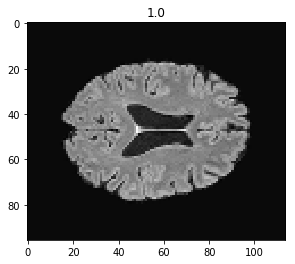

In [9]:
plt.imshow(images_X_train[0][:,:,49], cmap='gray')
plt.title(y_train[0])
plt.show()

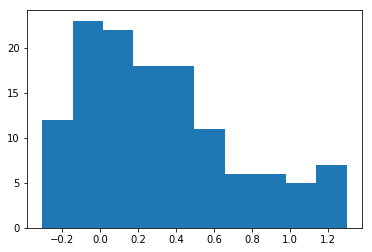

In [10]:
plt.hist(X_train[0])
plt.show()

## Training

In [11]:
X_train.shape

(124, 128)

In [12]:
from sklearn.model_selection import GridSearchCV
#from sklearn import svm, grid_search

def svc_param_selection(X, y, n_folds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    kernels = ['linear', 'rbf']
    param_grid = {'C': Cs,
                  'kernel': kernels}
    grid_search = GridSearchCV(SVC(gamma='auto'), param_grid, cv=n_folds, n_jobs=10)
    grid_search.fit(X, y)
    grid_search.best_params_
    #print(grid_search.cv_results_)
    return grid_search.best_params_, grid_search.cv_results_

Fold 0


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Best parameter value: {'C': 1, 'kernel': 'rbf'}
######## Training set results ########
Balanced accuracy 93.38 %
Sensitivity 92.31 %
Specificity 94.44 %
######## Validation set results ########
Balanced accuracy 100.00 %
Sensitivity 100.00 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 100.00
Fold 1


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Best parameter value: {'C': 1, 'kernel': 'rbf'}
######## Training set results ########
Balanced accuracy 95.23 %
Sensitivity 92.31 %
Specificity 98.15 %
######## Validation set results ########
Balanced accuracy 92.86 %
Sensitivity 100.00 %
Specificity 85.71 %
Area Under the Receiver Operating Curve (ROC AUC score) 100.00
Fold 2


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Best parameter value: {'C': 1, 'kernel': 'rbf'}
######## Training set results ########
Balanced accuracy 96.35 %
Sensitivity 94.74 %
Specificity 97.96 %
######## Validation set results ########
Balanced accuracy 79.17 %
Sensitivity 66.67 %
Specificity 91.67 %
Area Under the Receiver Operating Curve (ROC AUC score) 89.58
Fold 3


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Best parameter value: {'C': 10, 'kernel': 'rbf'}
######## Training set results ########
Balanced accuracy 95.28 %
Sensitivity 94.34 %
Specificity 96.23 %
######## Validation set results ########
Balanced accuracy 95.00 %
Sensitivity 90.00 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 100.00
Fold 4


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameter value: {'C': 0.1, 'kernel': 'linear'}
######## Training set results ########
Balanced accuracy 94.34 %
Sensitivity 92.45 %
Specificity 96.23 %
######## Validation set results ########
Balanced accuracy 100.00 %
Sensitivity 100.00 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 100.00
Fold 5
Best parameter value: {'C': 0.01, 'kernel': 'linear'}


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


######## Training set results ########
Balanced accuracy 94.47 %
Sensitivity 92.86 %
Specificity 96.08 %
######## Validation set results ########
Balanced accuracy 95.00 %
Sensitivity 100.00 %
Specificity 90.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 98.57
Fold 6
Best parameter value: {'C': 0.1, 'kernel': 'linear'}
######## Training set results ########
Balanced accuracy 96.21 %
Sensitivity 98.18 %
Specificity 94.23 %
######## Validation set results ########
Balanced accuracy 87.50 %
Sensitivity 75.00 %
Specificity 100.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 87.50
Training Time: 0.0h:0.0m:47.94645929336548s
######## Final results ########
Validation balanced accuracies: 
 [1.0, 0.9285714285714286, 0.7916666666666666, 0.95, 1.0, 0.95, 0.875]
Validation balanced accuracies mean: 0.927891156462585
Validation final sensitivities: 
 [1.0, 1.0, 0.6666666666666666, 0.9, 1.0, 1.0, 0.75]
Validation final sensitivities' mean: 0.9023809523809524
Validation f

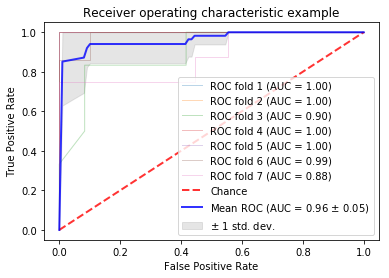

In [13]:
kf = KFold(n_splits=7)
fold = 0

best_params = []
train_balanced_accuracies = []
train_sensitivities = []
train_specificities = []

val_balanced_accuracies = []
val_sensitivities = []
val_specificities = []

auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

# shuffle the data once
X_train, y_train = shuffle_data(X_train, y_train)

# nested cross-validation
for train_idx, test_idx in kf.split(X_train):
    print("Fold %i" %fold)
    fold += 1
    
    # Start inner cross-validation
    best_param, cv_result = svc_param_selection(
        X_train[train_idx],
        y_train[train_idx],
        n_folds=5)
    
    print("Best parameter value: {}".format(best_param))
    
    model = SVC(kernel=best_param["kernel"], C=best_param["C"])
    model.fit(X_train[train_idx], y_train[train_idx])
    
    # training set results
    train_pred = model.predict(X_train[train_idx])
    train_bal_acc = balanced_accuracy(y_train[train_idx], train_pred)
    train_sens = sensitivity(y_train[train_idx], train_pred)
    train_spec = specificity(y_train[train_idx], train_pred)
    # val set results
    val_pred = model.predict(X_train[test_idx])
    val_scores = model.decision_function(X_train[test_idx])
    val_bal_acc = balanced_accuracy(y_train[test_idx], val_pred)
    val_sens = sensitivity(y_train[test_idx], val_pred)
    val_spec = specificity(y_train[test_idx], val_pred)
    
    roc_auc = roc_auc_score(y_train[test_idx], val_scores)
    fpr, tpr, thresholds = roc_curve(y_train[test_idx], val_scores)   
    
    # Store results
    best_params.append(best_param)
    train_balanced_accuracies.append(train_bal_acc)
    train_sensitivities.append(train_sens)
    train_specificities.append(train_spec)
    val_balanced_accuracies.append(val_bal_acc)
    val_sensitivities.append(val_sens)
    val_specificities.append(val_spec)
    
    auc_scores.append(roc_auc)
    # interpolate with diagonal to get comparable results
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0 # correct lowest value after interpolation

    # Print results
    print("######## Training set results ########")
    print("Balanced accuracy {:.2f} %".format(train_bal_acc*100))
    print("Sensitivity {:.2f} %".format(train_sens*100))
    print("Specificity {:.2f} %".format(train_spec*100))
    print("######## Validation set results ########")
    print("Balanced accuracy {:.2f} %".format(val_bal_acc*100))
    print("Sensitivity {:.2f} %".format(val_sens*100))
    print("Specificity {:.2f} %".format(val_spec*100))
    print("Area Under the Receiver Operating Curve (ROC AUC score) {:.2f}".format(roc_auc*100))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (fold, roc_auc))
    
training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
# Print results
print("######## Final results ########")
print("Validation balanced accuracies: \n {}".format(val_balanced_accuracies))
print("Validation balanced accuracies mean: {}".format(np.mean(val_balanced_accuracies)))
print("Validation final sensitivities: \n {}".format(val_sensitivities))
print("Validation final sensitivities' mean: {}".format(np.mean(val_sensitivities)))
print("Validation final specificities: \n {}".format(val_specificities))
print("Validation final specificities' mean: {}".format(np.mean(val_specificities)))
print("Mean ROC AUC score {:.2f}".format(np.mean(auc_scores)*100))

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # correct max value after interpolation and mean
mean_auc = auc(mean_fpr, mean_tpr)
#assert(mean_auc == np.mean(auc_scores))

std_auc = np.std(auc_scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [14]:
training_time = time.time() - start_time

In [15]:
counter = {}

In [16]:
def majority_vote(best_params):
    """
    Find the most often used combination 
    of parameters.
    """
    assert(len(best_params)>=1)
    counter = {}
    # count unique value list
    for i in range(len(best_params)):
        # turn values into key
        new_key = ""
        for x in list(best_params[i].values()):
            new_key = new_key + str(x) + "_"
        if new_key in counter.keys():
            counter[new_key] += 1
        else:
            counter[new_key] = 1
    # select most frequent value list
    majority_param = max(counter, key=lambda key: counter[key])
    # reformat to list
    majority_param = majority_param[:-1].split("_")
    # reformat to dictionary
    result = {}
    for key, value in zip(best_params[0].keys(), majority_param):
        result[key] = value
    return result

In [17]:
majority_param = majority_vote(best_params)
print(majority_param)

{'C': '1', 'kernel': 'rbf'}


# Evaluation

Train on the entire training set with the best parameters from above and test on the holdout dataset for final performance.

Trial 0
######## Training set results ########
Balanced accuracy 95.19 %
Sensitivity 93.65 %
Specificity 96.72 %
######## Holdout set results ########
Balanced accuracy 85.00 %
Sensitivity 100.00 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 98.46
Trial 1
######## Training set results ########
Balanced accuracy 95.19 %
Sensitivity 93.65 %
Specificity 96.72 %
######## Holdout set results ########
Balanced accuracy 85.00 %
Sensitivity 100.00 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 98.46
Trial 2
######## Training set results ########
Balanced accuracy 95.19 %
Sensitivity 93.65 %
Specificity 96.72 %
######## Holdout set results ########
Balanced accuracy 85.00 %
Sensitivity 100.00 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 98.46
Trial 3
######## Training set results ########
Balanced accuracy 95.19 %
Sensitivity 93.65 %
Specificity 96.72 %
######## Holdout set results ########
Balanced 

/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/

######## Training set results ########
Balanced accuracy 95.19 %
Sensitivity 93.65 %
Specificity 96.72 %
######## Holdout set results ########
Balanced accuracy 85.00 %
Sensitivity 100.00 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 98.46
Trial 7
######## Training set results ########
Balanced accuracy 95.19 %
Sensitivity 93.65 %
Specificity 96.72 %
######## Holdout set results ########
Balanced accuracy 85.00 %
Sensitivity 100.00 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 98.46
Trial 8
######## Training set results ########
Balanced accuracy 95.19 %
Sensitivity 93.65 %
Specificity 96.72 %
######## Holdout set results ########
Balanced accuracy 85.00 %
Sensitivity 100.00 %
Specificity 70.00 %
Area Under the Receiver Operating Curve (ROC AUC score) 98.46
Trial 9
######## Training set results ########
Balanced accuracy 95.19 %
Sensitivity 93.65 %
Specificity 96.72 %
######## Holdout set results ########
Balanced accuracy

/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/fabiane/.local/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


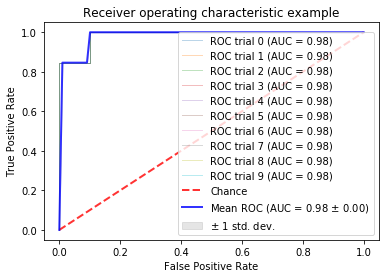

In [18]:
# training args
#kernel = "linear"
kernel = majority_param["kernel"]
C = float(majority_param["C"])
model = SVC(kernel=kernel, C=C, cache_size=2000)
#model = LinearSVC(C=C, max_iter=5000)

num_trials = 10

train_balanced_accuracies = []
train_sensitivities = []
train_specificities = []

holdout_balanced_accuracies = []
holdout_sensitivities = []
holdout_specificities = []

auc_scores = []
tprs = []
mean_fpr = np.linspace(0, 1, 100)

for i in range(num_trials):
    print("Trial %i" %i)
    
    # shuffle the data
    X_train, y_train = shuffle_data(X_train, y_train)
    
    # Start training
    model.fit(X_train, y_train)
    # training set results
    train_pred = model.predict(X_train)
    train_bal_acc = balanced_accuracy(y_train, train_pred)
    train_sens = sensitivity(y_train, train_pred)
    train_spec = specificity(y_train, train_pred)
    # holdout set results
    holdout_pred = model.predict(X_holdout)
    holdout_scores = model.decision_function(X_holdout)
    holdout_bal_acc = balanced_accuracy(y_holdout, holdout_pred)
    holdout_sens = sensitivity(y_holdout, holdout_pred)
    holdout_spec = specificity(y_holdout, holdout_pred)
    
    roc_auc = roc_auc_score(y_holdout, holdout_scores)
    fpr, tpr, thresholds = roc_curve(y_holdout, holdout_scores)   
    
    # Store results
    train_balanced_accuracies.append(train_bal_acc)
    train_sensitivities.append(train_sens)
    train_specificities.append(train_spec)
    holdout_balanced_accuracies.append(holdout_bal_acc)
    holdout_sensitivities.append(holdout_sens)
    holdout_specificities.append(holdout_spec)
    
    auc_scores.append(roc_auc)
    # interpolate with diagonal to get comparable results
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0 # correct lowest value after interpolation

    # Print results
    print("######## Training set results ########")
    print("Balanced accuracy {:.2f} %".format(train_bal_acc*100))
    print("Sensitivity {:.2f} %".format(train_sens*100))
    print("Specificity {:.2f} %".format(train_spec*100))
    print("######## Holdout set results ########")
    print("Balanced accuracy {:.2f} %".format(holdout_bal_acc*100))
    print("Sensitivity {:.2f} %".format(holdout_sens*100))
    print("Specificity {:.2f} %".format(holdout_spec*100))
    print("Area Under the Receiver Operating Curve (ROC AUC score) {:.2f}".format(roc_auc*100))
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC trial %d (AUC = %0.2f)' % (i, roc_auc))
    
training_time = time.time() - start_time
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
# Print results
print("######## Final results ########")
print("Holdout balanced accuracies: \n {}".format(holdout_balanced_accuracies))
print("Holdout balanced accuracies mean: {}".format(np.mean(holdout_balanced_accuracies)))
print("Holdout final sensitivities: \n {}".format(holdout_sensitivities))
print("Holdout final sensitivities' mean: {}".format(np.mean(holdout_sensitivities)))
print("Holdout final specificities: \n {}".format(holdout_specificities))
print("Holdout final specificities' mean: {}".format(np.mean(holdout_specificities)))
print("Mean ROC AUC score {:.2f}".format(np.mean(auc_scores)*100))

# Plot ROC Curves
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0 # correct max value after interpolation and mean
mean_auc = auc(mean_fpr, mean_tpr)
#assert(mean_auc == np.mean(auc_scores))

std_auc = np.std(auc_scores)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [19]:
total_time = time.time() - start_time

In [20]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))
print("Total time elapsed: {}h:{}m:{}s".format(
            total_time//3600, (total_time//60)%60, total_time%60))

Training Time: 0.0h:0.0m:49.892295837402344s
Total time elapsed: 0.0h:0.0m:50.676344871520996s


In [21]:
quit()